In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import yfinance as yfin

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM

In [6]:
#Long short term memory (LSTM)

#Load Data(Ticker Symbol)
yfin.pdr_override()
company = "GOOG"

start = dt.datetime(2022,5,1)
end = dt.datetime(2024,3,29)

#Scraping data from web
data = web.get_data_yahoo(company , start , end)

#Prepare data_data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 100

x_train = []
y_train = []

for x in range(prediction_days,len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train ,(x_train.shape[0],x_train.shape[1],1))


[*********************100%%**********************]  1 of 1 completed


In [9]:

#Build model
model = Sequential()
model.add(LSTM(units = 150,return_sequences = True , input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 100,return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

#Prediction of the next closing price
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train , y_train , epochs = 50, batch_size = 32)

''' Test the model accuracy on existing data '''

#Loading test data
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.get_data_yahoo(company , test_start , test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'],test_data['Close']),axis = 0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1) # type: ignore
model_inputs = scaler.transform(model_inputs)

#Make predictions on test data
x_test = []

for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.1137
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0216
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0186
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0133
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0102
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 0.0079
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.0094
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0088
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0083
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.0085
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0074
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0071
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0078
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0086
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - lo

[*********************100%%**********************]  1 of 1 completed


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step


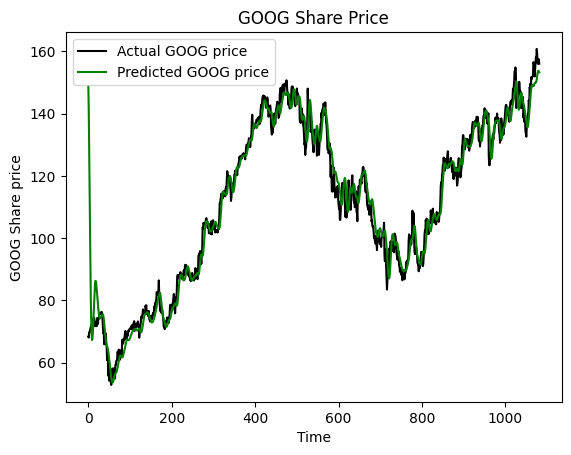

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
Prediction [[152.94417]]


In [15]:
#Plot the test predictions
plt.plot(actual_prices , color = "black" , label = f"Actual {company} price")
plt.plot(predicted_prices , color = "green" , label = f"Predicted {company} price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f"{company} Share price")
plt.legend()
plt.show()

if __name__ == "__main__":
    # Predicting next day
    real_data = [model_inputs[len(model_inputs) + 1 - prediction_days: len(model_inputs) + 1, 0]]
    real_data = np.array(real_data)
    real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

    prediction = model.predict(real_data)
    prediction = scaler.inverse_transform(prediction)

    print(f"Prediction {prediction}")